In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import dagshub
import mlflow

import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, make_scorer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

cwd = os.getcwd()

for dirname, _, filenames in os.walk(f'{cwd}/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/b3tameche/uni/ml/assignments/kaggle-house-prices/input/data_description.txt
/home/b3tameche/uni/ml/assignments/kaggle-house-prices/input/test.csv
/home/b3tameche/uni/ml/assignments/kaggle-house-prices/input/train.csv
/home/b3tameche/uni/ml/assignments/kaggle-house-prices/input/sample_submission.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# to ignore warnings in cells
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(f'{cwd}/input/train.csv')

In [4]:
random_state = 42

def show_na_means(df):
  na_means = df.isna().mean()
  print(na_means[na_means > 0])

def get_cat_num_cols(df):
  cat_cols = [col for col in df.columns if df[col].dtype == 'object']
  num_cols = [col for col in df.columns if df[col].dtype != 'object']
  return (cat_cols, num_cols)

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.shape

(1460, 81)

# Setting up MLFlow

In [7]:
dagshub.init(repo_owner='b3tameche', repo_name='kaggle-house-prices', mlflow=True)

Accessing as b3tameche

Initialized MLflow to track repo "b3tameche/kaggle-house-prices"

Repository b3tameche/kaggle-house-prices initialized!

# Train/Validation split

In [8]:
# entire trainset
X = df.drop(['Id'], axis=1)

# prepare data for cross validation, use 20% of training data for validation purposes
X_train, X_test = train_test_split(X, test_size=0.2, random_state=random_state)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [9]:
X_train.shape, y_train.shape

((1168, 79), (1168,))

In [10]:
show_na_means(X_train)

LotFrontage    0.185788
Alley          0.936644
MasVnrType     0.584760
MasVnrArea     0.005137
BsmtQual       0.023973
                 ...   
GarageQual     0.054795
GarageCond     0.054795
PoolQC         0.994863
Fence          0.800514
MiscFeature    0.960616
Length: 19, dtype: float64


In [11]:
show_na_means(X_test)

LotFrontage    0.143836
Alley          0.941781
MasVnrType     0.647260
MasVnrArea     0.006849
BsmtQual       0.030822
                 ...   
GarageQual     0.058219
GarageCond     0.058219
PoolQC         0.996575
Fence          0.835616
MiscFeature    0.972603
Length: 18, dtype: float64


In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 79), (292, 79), (1168,), (292,))

<Axes: >

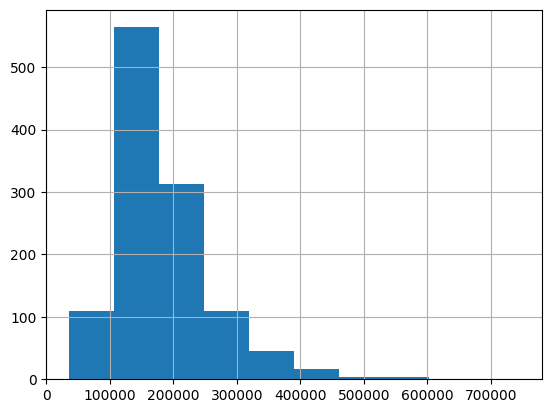

In [13]:
y_train.hist()

In [14]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

<Axes: >

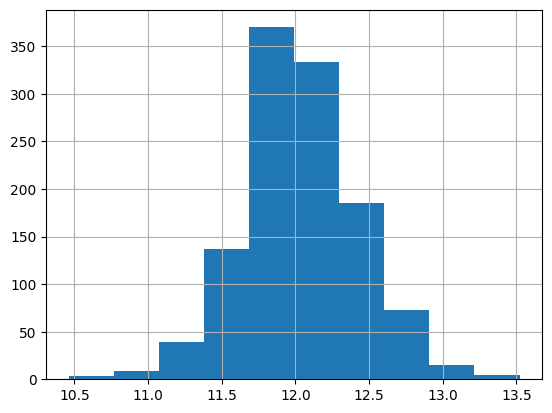

In [15]:
y_train_log.hist()

##### Log target variable distribution before vs after.

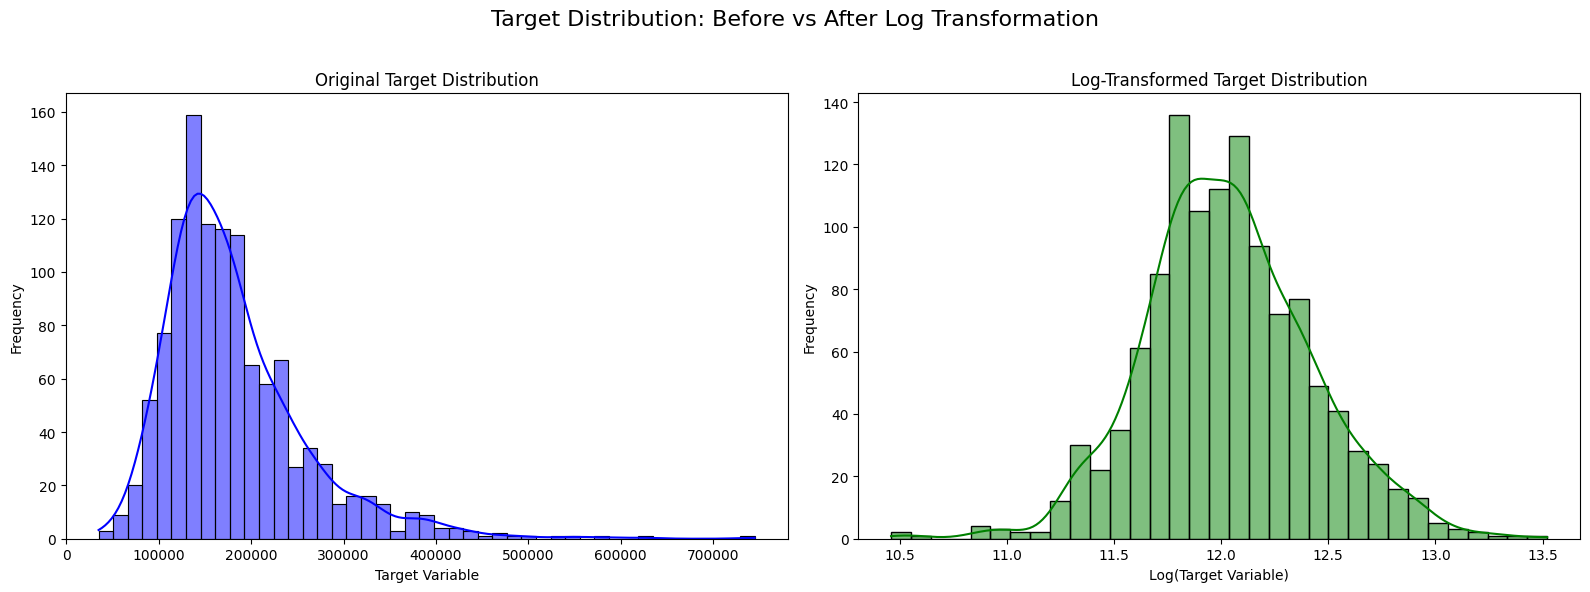

In [16]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot original distribution
sns.histplot(y_train, kde=True, ax=ax1, color='blue')
ax1.set_title('Original Target Distribution')
ax1.set_xlabel('Target Variable')
ax1.set_ylabel('Frequency')

# Plot log-transformed distribution
sns.histplot(y_train_log, kde=True, ax=ax2, color='green')
ax2.set_title('Log-Transformed Target Distribution')
ax2.set_xlabel('Log(Target Variable)')
ax2.set_ylabel('Frequency')

# Add a main title to the entire figure
fig.suptitle('Target Distribution: Before vs After Log Transformation', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle

plt.savefig("Target_Distribution_Before_After_Log.png")

In [17]:
run_log_target_distribution = "Target_Variable_Distribution_Log"

experiment_target_distribution = "Default"

mlflow.set_experiment(experiment_target_distribution)

with mlflow.start_run(run_name=run_log_target_distribution):
  mlflow.log_artifact("Target_Distribution_Before_After_Log.png")

🏃 View run Target_Variable_Distribution_Log at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/0/runs/e2f829fcca3a4f9ab462ec607ed831d4
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/0


# Preprocessing

## Handling N/As

In [18]:
class NAPreprocessor(BaseEstimator, TransformerMixin):
  """This preprocessor fills N/As in dataset."""

  def __init__(self, nullable_columns: list[str], linked_columns: dict):
    # ones with intentional N/A values
    self.nullable_columns = nullable_columns

    # linked features
    self.linked_columns = linked_columns

  def fit(self, X, y):
    self.cat_cols, self.num_cols = get_cat_num_cols(X)

    self.cat_cols_modes = {}
    for catcol in self.cat_cols:
      self.cat_cols_modes[catcol] = X[catcol].mode().iloc[0]
    
    self.num_cols_medians = {}
    for numcol in self.num_cols:
      self.num_cols_medians[numcol] = X[numcol].median()

    return self

  def transform(self, X):
    X_work = X.copy()

    # 1. fill ones with intentional N/A values
    for col in self.nullable_columns:
      X_work.fillna({col: 'None'}, inplace=True)

    # 2. fill ones that should be filled with 0 depending on parent column value
    for col, parent_col in self.linked_columns.items():

      # [parent, col] where col is N/A
      none_rows = X_work[[parent_col, col]][X_work[col].isna()]

      # parent_col is None where col is N/A (means that it should be replaced by 0)
      condition = len(none_rows) == len(none_rows[none_rows[parent_col] == 'None'])
      if condition:
        X_work.fillna({col: 0}, inplace=True)

    
    # 3. fill categorical missing values with mode
    for catcol in self.cat_cols:
      X_work.fillna({catcol: self.cat_cols_modes[catcol]}, inplace=True)

    # 4. fill numerical missing values with median
    for numcol in self.num_cols:
      X_work.fillna({numcol: self.num_cols_medians[numcol]}, inplace=True)
    
    return X_work

In [19]:
nullable_columns = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
linked_columns = {
  'MasVnrArea': 'MasVnrType',
  'BsmtFinSF1': 'BsmtFinType1',
  'BsmtFinSF2': 'BsmtFinType2',
  'Fireplaces': 'FireplaceQu',
  'GarageCars': 'GarageType',
  'GarageArea': 'GarageType',
  'PoolArea': 'PoolQC',
  'MiscVal': 'MiscFeature'
}

na_preprocessor = NAPreprocessor(nullable_columns=nullable_columns, linked_columns=linked_columns)
X_train_na = na_preprocessor.fit_transform(X_train, y_train_log)
X_test_na = na_preprocessor.transform(X_test)

In [20]:
X_train_na.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RL,70.0,8400,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,None,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,None,None,None,0,6,2010,WD,Normal
1,60,RL,59.0,7837,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,5,2009,WD,Normal
2,30,RL,67.0,8777,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,None,None,1980.0,None,0,0,None,None,P,328,0,164,0,0,0,None,MnPrv,None,0,5,2008,WD,Normal
3,50,RL,60.0,7200,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,None,MnPrv,None,0,6,2007,WD,Normal
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,None,None,None,0,5,2010,WD,Normal


In [21]:
# should not have N/As
X_train_na.isna().any().sum()

np.int64(0)

In [22]:
# should not have N/As
X_test_na.isna().any().sum()

np.int64(0)

## Dropping irrelevant columns

In [23]:
class DropperPreprocessor(BaseEstimator, TransformerMixin):
  """This preprocessor drops columns."""

  def __init__(self, columns_to_drop: list[str]):
    self.columns_to_drop = columns_to_drop
  
  def fit(self, X, y):
    return self

  def transform(self, X):
    X_work = X.copy()

    # drop explicit columns
    X_work.drop(self.columns_to_drop, axis=1, inplace=True)

    return X_work

In [24]:
columns_to_drop = ['Street', 'Utilities', 'PoolQC', 'MoSold', 'YearBuilt']

dropper_preprocessor = DropperPreprocessor(columns_to_drop=columns_to_drop)
X_train_dropped = dropper_preprocessor.fit_transform(X_train_na, y_train_log)
X_test_dropped = dropper_preprocessor.transform(X_test_na)

In [25]:
X_train_dropped.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition
0,20,RL,70.0,8400,None,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,None,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,None,None,0,2010,WD,Normal
1,60,RL,59.0,7837,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,None,None,0,2009,WD,Normal
2,30,RL,67.0,8777,None,Reg,Lvl,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,None,None,1980.0,None,0,0,None,None,P,328,0,164,0,0,0,MnPrv,None,0,2008,WD,Normal
3,50,RL,60.0,7200,None,Reg,Lvl,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,MnPrv,None,0,2007,WD,Normal
4,50,RL,50.0,5000,Pave,Reg,Lvl,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,None,None,0,2010,WD,Normal


In [26]:
X_train_dropped.shape, X_test_dropped.shape, y_train_log.shape, y_test_log.shape

((1168, 74), (292, 74), (1168,), (292,))

## Explicit Conversions

In [27]:
class ExplicitEncoderPreprocessor(BaseEstimator, TransformerMixin):
  """This preprocessor performs explicit conversions from categorical to numerical columns."""

  def __init__(self):
    # I do not pass below mappings as parameters, because it's less likely to change them.
    pass
  
  def fit(self, X, y):
    # Some features can simply be represented as numerical ones.
    # Transition grade depends on how much difference is between each type of value.
    self.feature_to_mapping: dict[str, dict[str, int]] = {
      'ExterQual':    { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2 },
      'ExterCond':    { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2 },
      'BsmtQual':     { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2, 'None': 0 },
      'BsmtCond':     { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2, 'None': 0 },
      'BsmtExposure': { 'Gd': 8, 'Av': 6, 'Mn': 4, 'No': 2, 'None': 0 },
      'BsmtFinType1': { 'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0 },
      'BsmtFinType2': { 'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0 },
      'HeatingQC':    { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2 },
      'KitchenQual':  { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2 },
      'Functional':   { 'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0 },
      'FireplaceQu':  { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2, 'None': 0 },
      'GarageFinish': { 'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 },
      'GarageQual':   { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2, 'None': 0 },
      'GarageCond':   { 'Ex': 10, 'Gd': 8, 'TA': 6, 'Fa': 4, 'Po': 2, 'None': 0 },
      'Fence':        { 'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0 }
    }
    
    # I decide to create matrix for 2 columns below
    # condition1 and condition2 can be converted into "has_cond" matrix, and if row has both condition1 and condition2, in matrix, True (i.e. 1) will be set for both conditions
    self.condition_possible_values = ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe']

    # same for Exterior1st and Exterior2nd
    self.exterior_possible_values = ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd', 'WdShing']

    return self
  
  def transform(self, X):
    X_work = X.copy()

    # 1
    for each in self.condition_possible_values:
      new_column_name = f'has_{each}'
      X_work[new_column_name] = ((X_work['Condition1'] == each) | (X_work['Condition2'] == each)).astype('int')

    X_work.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

    for each in self.exterior_possible_values:
      new_column_name = f'has_{each}'
      X_work[new_column_name] = ((X_work['Exterior1st'] == each) | (X_work['Exterior2nd'] == each)).astype('int')

    X_work.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

    # 2
    # MSSubClass is actually categoric variable instead of numeric.
    X_work['MSSubClass'] = X_work['MSSubClass'].astype('object')

    # 3
    for feature, mapping in self.feature_to_mapping.items():
      self.map_to_categories(X_work, feature, mapping)

    return X_work
  
  def map_to_categories(self, df, column, mapping):
    """Maps column values to corresponding value from `mapping`"""
    df[column] = df[column].map(mapping)

In [28]:
explicit_encoder_preprocessor = ExplicitEncoderPreprocessor()

X_train_explicitly_converted = explicit_encoder_preprocessor.fit_transform(X_train_dropped, y_train_log)
X_test_explicitly_converted = explicit_encoder_preprocessor.transform(X_test_dropped)

In [29]:
X_train_explicitly_converted.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,has_Artery,has_Feedr,has_Norm,has_RRNn,has_RRAn,has_PosN,has_PosA,has_RRNe,has_RRAe,has_AsbShng,has_AsphShn,has_BrkComm,has_BrkFace,has_CBlock,has_CemntBd,has_HdBoard,has_ImStucc,has_MetalSd,has_Other,has_Plywood,has_PreCast,has_Stone,has_Stucco,has_VinylSd,has_Wd,has_WdShing
0,20,RL,70.0,8400,None,Reg,Lvl,Inside,Gtl,NAmes,1Fam,1Story,5,6,1957,Gable,CompShg,None,0.0,6,8,CBlock,6,6,2,3,922,1,0,392,1314,GasA,6,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,6,5,7,0,0,Attchd,1957.0,2,1,294,6,6,Y,250,0,0,0,0,0,0,None,0,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60,RL,59.0,7837,None,IR1,Lvl,Inside,Gtl,Gilbert,1Fam,2Story,6,7,1994,Gable,CompShg,None,0.0,8,6,PConc,8,6,2,1,0,1,0,799,799,GasA,8,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,6,7,7,1,6,Attchd,1993.0,2,2,380,6,6,Y,0,40,0,0,0,0,0,None,0,2009,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,30,RL,67.0,8777,None,Reg,Lvl,Inside,Gtl,Edwards,1Fam,1Story,5,7,1950,Gable,CompShg,None,0.0,6,6,CBlock,4,6,2,1,0,1,0,796,796,GasA,8,Y,FuseA,796,0,0,796,0,0,1,0,2,1,6,4,7,0,0,None,1980.0,0,0,0,0,0,P,328,0,164,0,0,0,3,None,0,2008,WD,Normal,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,50,RL,60.0,7200,None,Reg,Lvl,Corner,Gtl,SWISU,1Fam,1.5Fin,5,7,1950,Gable,CompShg,BrkFace,252.0,6,6,BrkTil,8,6,2,5,569,1,0,162,731,GasA,10,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,8,7,7,2,6,Detchd,1939.0,1,1,240,6,6,Y,0,0,264,0,0,0,3,None,0,2007,WD,Normal,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50,RL,50.0,5000,Pave,Reg,Lvl,Inside,Gtl,SWISU,1Fam,1.5Fin,5,6,1950,Gable,CompShg,None,0.0,6,6,BrkTil,6,6,2,2,218,1,0,808,1026,GasA,6,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,8,6,7,1,8,Detchd,1924.0,1,1,308,6,6,Y,0,0,242,0,0,0,0,None,0,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X_train_explicitly_converted.shape, X_test_explicitly_converted.shape

((1168, 96), (292, 96))

## Feature Engineering

In [31]:
class FeatureEngineerPreprocessor(BaseEstimator, TransformerMixin):
  """This preprocessor performs custom feature engineering."""

  def __init__(self):
    super().__init__()
  
  def fit(self, X, y):
    return self

  def transform(self, X):
    X_work = X.copy()

    X_work['has_CentralAir'] = np.where(X_work['CentralAir'] == 'N', 0, 1)
    X_work.drop('CentralAir', axis=1, inplace=True)

    # Pool
    X_work['has_pool'] = np.where(X_work['PoolArea'] > 0, 1, 0)
    X_work.drop('PoolArea', axis=1, inplace=True)

    # Second Floor
    X_work['has_2ndFlr'] = np.where(X_work['2ndFlrSF'] > 0, 1, 0)

    # Fireplaces
    X_work['has_fireplace'] = np.where(X_work['Fireplaces'] > 0, 1, 0)

    # Garage
    X_work['has_garage'] = np.where(X_work['GarageType'] != 'None', 1, 0)

    # WoodDeckSF
    X_work['has_woodDeck'] = np.where(X_work['WoodDeckSF'] > 0, 1, 0)

    # total square footage = basement + GrLivArea
    X_work['TotalSF'] = X_work['TotalBsmtSF'] + X_work['GrLivArea']

    # total bathroom score = full bathrooms in house + full bathrooms in basement + (0.5 * half bathrooms in house) + (0.5 * half bathrooms in basement)
    X_work['TotalBath'] = X_work['FullBath'] + X_work['HalfBath'] * 0.5 + X_work['BsmtFullBath'] + X_work['BsmtHalfBath'] * 0.5

    # total porch square footage = (3 season + open + screen + enclosed) porchs
    X_work['TotalPorchSF'] = X_work['3SsnPorch'] + X_work['OpenPorchSF'] + X_work['ScreenPorch'] + X_work['EnclosedPorch']

    return X_work

In [32]:
feature_engineer_preprocessor = FeatureEngineerPreprocessor()

X_train_fe = feature_engineer_preprocessor.fit_transform(X_train_explicitly_converted, y_train_log)
X_test_fe = feature_engineer_preprocessor.transform(X_test_explicitly_converted)

In [33]:
X_train_fe.shape, X_test_fe.shape

((1168, 103), (292, 103))

## Categoric To numeric conversions

In [34]:
class GeneralEncoderPreprocessor(BaseEstimator, TransformerMixin):
  """
  This preprocessor performs conversions automatically, without explicitly defined mappings.  
  Basically, it's sklearn.preprocessing.OneHotEncoder wrapper.
  """

  def __init__(self):
    self.onehot_encoder = OneHotEncoder(dtype='int', drop='first', handle_unknown='ignore', sparse_output=False)

  def fit(self, X, y):
    X_work = X.copy()

    self.cat_cols, self.num_cols = get_cat_num_cols(X)

    # only retain categorical columns for One-Hot Encoding
    X_work = X_work[self.cat_cols]

    self.onehot_encoder.fit(X_work)

    return self

  def transform(self, X):
    X_work = X.copy()

    X_work_cat = X_work[self.cat_cols]
    X_work_num = X_work[self.num_cols]

    X_work_onehot = pd.DataFrame(self.onehot_encoder.transform(X_work_cat), columns=self.onehot_encoder.get_feature_names_out())

    X_work_concat = pd.concat([X_work_num, X_work_onehot], axis=1)

    return X_work_concat

In [35]:
general_encoder_preprocessor = GeneralEncoderPreprocessor()

X_train_num = general_encoder_preprocessor.fit_transform(X_train_fe, y_train_log)
X_test_num = general_encoder_preprocessor.transform(X_test_fe)

In [36]:
X_train_num.isna().any().sum(), X_test_num.isna().any().sum()

(np.int64(0), np.int64(0))

In [37]:
X_train_num.shape, X_test_num.shape

((1168, 201), (292, 201))

## Correlation Filter

In [38]:
class CorrelationFilterPreprocessor(BaseEstimator, TransformerMixin):
  """Removes original and engineered features with correlation higher than given threshold."""

  def __init__(self, correlation_threshold: float):
    self.correlation_threshold = correlation_threshold
  
  def fit(self, X, y):
    X_work = X.copy()

    woe_columns = [col for col in X_work.columns if 'woe' in col]

    # One-Hot encoded columns and any created ones (like has_something columns)
    derived_columns = [col for col in X_work.columns if (('_' in col) and (col not in set(woe_columns)))]
    
    # consisting of engineered features + initial original columns
    original_columns = [col for col in X_work.columns if (col not in woe_columns and col not in set(derived_columns))]

    correlation_columns = list(set(woe_columns + original_columns))

    X_work = X_work[correlation_columns]

    corr_matrix = X_work.corr().abs()
    pairs = []

    for i in range(len(corr_matrix.columns)):
      for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > self.correlation_threshold:
          col_i = corr_matrix.columns[i]
          col_j = corr_matrix.columns[j]

          pairs.append((col_i, col_j, corr_matrix.iloc[i, j]))
    
    temp_target_name = 'SalePrice'
    X_work[temp_target_name] = y

    # sort by correlation coefficients
    pairs.sort(key=lambda x: x[2], reverse=True)

    # print(pairs)
    
    self.features_to_drop = set()
    for feat1, feat2, _ in pairs:
      if feat1 in self.features_to_drop or feat2 in self.features_to_drop:
        # if one of them was already marked
        continue
      
      if abs(X_work[feat1].corr(X_work[temp_target_name])) < abs(X_work[feat2].corr(X_work[temp_target_name])):
        self.features_to_drop.add(feat1)
      else:
        self.features_to_drop.add(feat2)
    
    # print(f'Dropping total of {len(self.features_to_drop)} features: {self.features_to_drop}')
    
    return self

  def transform(self, X):
    X_work = X.copy()

    X_work.drop(list(self.features_to_drop), axis=1, inplace=True)

    # print(f'Final number of features: {len(X_work.columns)}')

    return X_work

In [39]:
correlation_filter_preprocessor = CorrelationFilterPreprocessor(correlation_threshold=0.8)

X_train_uncorrelated = correlation_filter_preprocessor.fit_transform(X_train_num, y_train_log)
X_test_uncorrelated = correlation_filter_preprocessor.transform(X_test_num)

In [40]:
X_train_uncorrelated.shape, X_test_uncorrelated.shape

((1168, 195), (292, 195))

In [41]:
X_train_uncorrelated.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,YrSold,has_Artery,has_Feedr,has_Norm,has_RRNn,has_RRAn,has_PosN,has_PosA,has_RRNe,has_RRAe,has_AsbShng,has_AsphShn,has_BrkComm,has_BrkFace,has_CBlock,has_CemntBd,has_HdBoard,has_ImStucc,has_MetalSd,has_Other,has_Plywood,has_PreCast,has_Stone,has_Stucco,has_VinylSd,has_Wd,has_WdShing,has_CentralAir,has_pool,has_2ndFlr,has_fireplace,has_garage,has_woodDeck,TotalSF,TotalBath,TotalPorchSF,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,70.0,8400,5,6,1957,0.0,6,8,6,6,2,3,922,1,0,392,6,0,0,1,0,1,0,3,1,6,5,7,0,1957.0,2,1,6,250,0,0,0,0,0,0,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,2628,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,59.0,7837,6,7,1994,0.0,8,6,8,6,2,1,0,1,0,799,8,772,0,0,0,2,1,3,1,6,7,7,6,1993.0,2,2,6,0,40,0,0,0,0,0,2009,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,2370,2.5,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,67.0,8777,5,7,1950,0.0,6,6,4,6,2,1,0,1,0,796,8,0,0,0,0,1,0,2,1,6,4,7,0,1980.0,0,0,0,328,0,164,0,0,3,0,2008,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1592,1.0,164,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0

## RFE

In [42]:
class RFEPreprocessor(BaseEstimator, TransformerMixin):
  def __init__(self, model, num_features: int, step: int):
    self.model = model

    self.scaler = StandardScaler()
    
    self.num_features = num_features
    self.step = step
  
  def fit(self, X, y):
    X_scaled = pd.DataFrame(
      self.scaler.fit_transform(X),
      columns=X.columns
    )

    rfe = RFE(estimator=self.model, n_features_to_select=self.num_features, step=self.step)
    rfe.fit(X_scaled, y)

    self.rfe_selected_features = X.columns[rfe.support_].tolist()

    # print("Features selected by RFE:")
    # for i, feature in enumerate(self.rfe_selected_features, 1):
    #   print(f"{i}. {feature}")
    
    return self

  def transform(self, X):
    X_work = X.copy()

    X_work = X_work[self.rfe_selected_features]
    # print(f'SELECTED: {self.rfe_selected_features}')

    return X_work

# Training

Prepare the preprocessed data which will be the same for every experiment.  
Define the scoring function.  
Define the cross validation strategy.

In [43]:
# N/A
nullable_columns = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
linked_columns = {
  'MasVnrArea': 'MasVnrType',
  'BsmtFinSF1': 'BsmtFinType1',
  'BsmtFinSF2': 'BsmtFinType2',
  'Fireplaces': 'FireplaceQu',
  'GarageCars': 'GarageType',
  'GarageArea': 'GarageType',
  'PoolArea': 'PoolQC',
  'MiscVal': 'MiscFeature'
}

# Dropper
columns_to_drop = ['Street', 'Utilities', 'PoolQC', 'MoSold', 'YearBuilt']

pipeline_preprocessor_immut = Pipeline([
  ('na_filler', NAPreprocessor(nullable_columns=nullable_columns, linked_columns=linked_columns)),
  ('dropper', DropperPreprocessor(columns_to_drop=columns_to_drop)),
  ('explicit_encoder', ExplicitEncoderPreprocessor()),
  ('feature_engineer', FeatureEngineerPreprocessor()),
  ('general_encoder', GeneralEncoderPreprocessor()),
])

X_train_immut = pipeline_preprocessor_immut.fit_transform(X_train, y_train_log)
X_test_immut = pipeline_preprocessor_immut.transform(X_test)

In [44]:
# define root mean squared error scorer
def rmse(y_true, y_pred):
  """
  Here `y_true` and `y_pred` are log values.  
  Mimics Kaggle scorer 1-1.
  """
  return root_mean_squared_error(y_true, y_pred)

rmse_scoring = make_scorer(rmse, greater_is_better=False)

In [45]:
# cross validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

##### Log preprocessor pipeline

In [46]:
experiment_preprocessor_pipeline = "Default"
run_preprocessor = "General_Preprocessor"

mlflow.set_experiment(experiment_preprocessor_pipeline)

with mlflow.start_run(run_name=run_preprocessor):
  
  # log preprocessing parameters
  mlflow.log_param('nullable_columns', nullable_columns)
  mlflow.log_param('linked_columns', linked_columns)
  mlflow.log_param('columns_to_drop', columns_to_drop)
  mlflow.log_param('random_state', random_state)

  mlflow.sklearn.log_model(pipeline_preprocessor_immut, "pipeline_preprocessor")

2025/04/09 19:17:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/09 19:17:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run General_Preprocessor at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/0/runs/e14c1281cd1a4ed4b092f2806eabd92b
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/0


### Plain Linear Regression

In [70]:
pipeline_linear = Pipeline([
  # correlation_threshold
  ('correlation_filter', CorrelationFilterPreprocessor(correlation_threshold=0)),

  # num_features
  ('rfe', RFEPreprocessor(model=LinearRegression(), num_features=0, step=1)),

  ('model', LinearRegression())
])

param_grid_linear = {
  'correlation_filter__correlation_threshold': [0.75, 0.8, 0.85],
  'rfe__num_features': [25, 55, 75],
}

grid_search_linear = GridSearchCV(
  pipeline_linear,
  param_grid=param_grid_linear,
  cv=kfold,
  scoring=rmse_scoring,
  verbose=0,
  return_train_score=True,
  n_jobs=-1
)

grid_search_linear.fit(X_train_immut, y_train_log)

best_params_linear = grid_search_linear.best_params_
best_estimator_linear = grid_search_linear.best_estimator_
best_score_linear = -grid_search_linear.best_score_

best_correlation_threshold_linear = best_params_linear['correlation_filter__correlation_threshold']
best_num_features_linear = best_params_linear['rfe__num_features']

In [48]:
# print best parameter combination
print(f"Best parameters: {best_params_linear}")

# print mean of split scores on test data
print(f"Best cross-validation score: {best_score_linear:.4f}")

Best parameters: {'correlation_filter__correlation_threshold': 0.75, 'rfe__num_features': 55}
Best cross-validation score: 0.1464


In [49]:
# print score on test data
y_pred = grid_search_linear.best_estimator_.predict(X_test_immut)
test_score_linear = rmse(y_test_log, y_pred)
print(test_score_linear)

0.19688168293847705


Since I have largely different test score on test set, I think I have overfitted the model. So I'll apply regularization, i.e. use regularized models.

##### Log Plain Linear Regression Model

In [54]:
experiment_linear = "Model_Linear_Regression_exp"
run_linear = "Linear_Regression_Best"

mlflow.set_experiment(experiment_linear)

with mlflow.start_run(run_name=run_linear):
  mlflow.log_param('random_state', random_state)
  mlflow.log_param('param_grid', param_grid_linear)
  mlflow.log_param('best_correlation_threshold', best_correlation_threshold_linear)
  mlflow.log_param('best_num_features', best_num_features_linear)

  mlflow.log_metric('best_RMSE_score_train', best_score_linear)
  mlflow.log_metric('best_RMSE_score_test', test_score_linear)
  
  mlflow.sklearn.log_model(best_estimator_linear, 'pipeline_linear')

2025/04/09 19:19:38 INFO mlflow.tracking.fluent: Experiment with name 'Model_Linear_Regression_exp' does not exist. Creating a new experiment.
2025/04/09 19:19:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Linear_Regression_Best at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/6/runs/57df0e6f1faa48e2bf8afbefef35a1cb
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/6


### Ridge Regression

In [71]:
alphas = [0.1, 1, 10]

best_run_ridge = None
best_score_ridge = float('inf')

for alpha in alphas:
  pipeline_ridge = Pipeline([
    # correlation_threshold
    ('correlation_filter', CorrelationFilterPreprocessor(correlation_threshold=0)),

    # alpha, num_features
    ('rfe', RFEPreprocessor(model=Ridge(alpha=alpha), num_features=0, step=1)),

    ('model', Ridge(alpha=alpha))
  ])

  param_grid_ridge = {
    'correlation_filter__correlation_threshold': [0.75, 0.8, 0.85],
    'rfe__num_features': [25, 55, 75]
  }

  grid_search_ridge = GridSearchCV(
    pipeline_ridge,
    param_grid=param_grid_ridge,
    cv=kfold,
    scoring=rmse_scoring,
    verbose=0,
    return_train_score=True,
    n_jobs=-1
  )

  grid_search_ridge.fit(X_train_immut, y_train_log)

  current_score = -grid_search_ridge.best_score_

  if current_score < best_score_ridge:
    best_params = grid_search_ridge.best_params_
    
    best_run_ridge = {
      'correlation_filter__correlation_threshold': best_params['correlation_filter__correlation_threshold'],
      'rfe__num_features': best_params['rfe__num_features'],
      'alpha': alpha,
      'score': current_score,
      'estimator': grid_search_ridge.best_estimator_
    }

    best_score_ridge = current_score

print()

best_correlation_threshold_ridge = best_run_ridge['correlation_filter__correlation_threshold']
best_num_features_ridge = best_run_ridge['rfe__num_features']
best_alpha_ridge = best_run_ridge['alpha']
best_score_ridge = best_run_ridge['score']
best_estimator_ridge = best_run_ridge['estimator']

print(f'best parameter combination: [correlation threshold: {best_correlation_threshold_ridge}, RFE num features: {best_num_features_ridge}, alpha: {best_alpha_ridge}]')
print(f'best score: {best_score_ridge}')


best parameter combination: [correlation threshold: 0.85, RFE num features: 75, alpha: 10]
best score: 0.1407082808671862


In [56]:
# print score on test data
y_pred = best_estimator_ridge.predict(X_test_immut)
test_score_ridge = rmse(y_test_log, y_pred)
print(test_score_ridge)

0.13844593428356222


We got a big improvement.

##### Log Ridge Regression

In [57]:
experiment_ridge = "Model_Ridge_Regression_exp"
run_ridge = "Ridge_Regression_Best"

mlflow.set_experiment(experiment_ridge)

with mlflow.start_run(run_name=run_ridge):
  mlflow.log_param('random_state', random_state)
  mlflow.log_param('param_grid', param_grid_ridge)
  mlflow.log_param('best_correlation_threshold', best_correlation_threshold_ridge)
  mlflow.log_param('best_num_features', best_num_features_ridge)
  mlflow.log_param('best_alpha', best_alpha_ridge)
  
  mlflow.log_metric('best_RMSE_score_train', best_score_ridge)
  mlflow.log_metric('best_RMSE_score_test', test_score_ridge)

  mlflow.sklearn.log_model(best_estimator_ridge, 'pipeline_ridge')

2025/04/09 19:20:09 INFO mlflow.tracking.fluent: Experiment with name 'Model_Ridge_Regression_exp' does not exist. Creating a new experiment.
2025/04/09 19:20:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_Regression_Best at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/7/runs/9fa7e07f58eb4572bac5f32c16aad15e
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/7


## Lasso Regression

In [72]:
alphas = [0.0005, 0.005, 0.01, 0.03]

best_run_lasso = None
best_score_lasso = float('inf')

for alpha in alphas:
  pipeline_lasso = Pipeline([
    # correlation_threshold
    ('correlation_filter', CorrelationFilterPreprocessor(correlation_threshold=0)),

    # alpha, num_features
    ('rfe', RFEPreprocessor(model=Lasso(alpha=alpha), num_features=0, step=1)),

    ('model', Lasso(alpha=alpha))
  ])

  param_grid_lasso = {
    'correlation_filter__correlation_threshold': [0.75, 0.8, 0.85],
    'rfe__num_features': [25, 55, 75]
  }

  grid_search_lasso = GridSearchCV(
    pipeline_lasso,
    param_grid=param_grid_lasso,
    cv=kfold,
    scoring=rmse_scoring,
    verbose=0,
    return_train_score=True,
    n_jobs=-1
  )

  grid_search_lasso.fit(X_train_immut, y_train_log)

  current_score = -grid_search_lasso.best_score_

  if current_score < best_score_lasso:
    best_params_lasso = grid_search_lasso.best_params_
    
    best_run_lasso = {
      'correlation_filter__correlation_threshold': best_params_lasso['correlation_filter__correlation_threshold'],
      'rfe__num_features': best_params_lasso['rfe__num_features'],
      'alpha': alpha,
      'score': current_score,
      'estimator': grid_search_lasso.best_estimator_
    }

    best_score_lasso = current_score

print()

best_correlation_threshold_lasso = best_run_lasso['correlation_filter__correlation_threshold']
best_num_features_lasso = best_run_lasso['rfe__num_features']
best_alpha_lasso = best_run_lasso['alpha']
best_score_lasso = best_run_lasso['score']
best_estimator_lasso = best_run_lasso['estimator']

print(f'best parameter combination: [correlation threshold: {best_correlation_threshold_lasso}, RFE num features: {best_num_features_lasso}, alpha: {best_alpha_lasso}]')
print(f'best score: {best_score_lasso}')


best parameter combination: [correlation threshold: 0.85, RFE num features: 75, alpha: 0.0005]
best score: 0.14074920052828865


In [59]:
# print score on test data
y_pred = best_estimator_lasso.predict(X_test_immut)
test_score_lasso = rmse(y_test_log, y_pred)
print(test_score_lasso)

0.13538068698341302


Best one so far.

##### Log Lasso Regression

In [67]:
experiment_lasso = "Model_Lasso_Regression_exp"
run_lasso = "Lasso_Regression_Best"

mlflow.set_experiment(experiment_lasso)

with mlflow.start_run(run_name=run_lasso):
  mlflow.log_param('random_state', random_state)
  mlflow.log_param('param_grid', param_grid_lasso)
  mlflow.log_param('best_correlation_threshold', best_correlation_threshold_lasso)
  mlflow.log_param('best_num_features', best_num_features_lasso)
  mlflow.log_param('best_alpha', best_alpha_lasso)

  mlflow.log_metric('best_RMSE_score_train', best_score_lasso)
  mlflow.log_metric('best_RMSE_score_test', test_score_lasso)

  mlflow.sklearn.log_model(best_estimator_lasso, 'pipeline_lasso')

2025/04/09 19:24:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso_Regression_Best at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/8/runs/778a8219a9104f29bbbf2a0d0363ba47
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/8


## Random Forest

In [73]:
pipeline_random_forest = Pipeline([
  # correlation_threshold
  ('correlation_filter', CorrelationFilterPreprocessor(correlation_threshold=0)),

  ('model', RandomForestRegressor(n_estimators=0, max_features=0, max_depth=0, min_samples_split=0, min_samples_leaf=0, random_state=random_state))
])

param_grid_random_forest = {
  'correlation_filter__correlation_threshold': [0.75, 0.8, 0.85],
  'model__n_estimators': [20, 50, 100],
  'model__max_features': ['auto', 'sqrt', 'log2'],
  'model__max_depth': [None, 10, 25],
  'model__min_samples_split': [3, 5, 10],
  'model__min_samples_leaf': [1, 2]
}

grid_search_random_forest = GridSearchCV(
  pipeline_random_forest,
  param_grid=param_grid_random_forest,
  cv=kfold,
  scoring=rmse_scoring,
  verbose=0,
  return_train_score=True,
  n_jobs=-1
)

grid_search_random_forest.fit(X_train_immut, y_train_log)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('correlation_filter',
                                        CorrelationFilterPreprocessor(correlation_threshold=0)),
                                       ('model',
                                        RandomForestRegressor(max_depth=0,
                                                              max_features=0,
                                                              min_samples_leaf=0,
                                                              min_samples_split=0,
                                                              n_estimators=0,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'correlation_filter__correlation_threshold': [0.75,
                                                                       0.8,
                                                                       0.85],
                         'model__max_depth': [None, 10, 25],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [3, 5, 10],
                         'model__n_estimators': [20, 50, 100]},
             return_train_score=True,
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [62]:
best_estimator_random_forest = grid_search_random_forest.best_estimator_
best_params_random_forest = grid_search_random_forest.best_params_
best_correlation_threshold_random_forest = best_params_random_forest['correlation_filter__correlation_threshold']
best_n_estimators_random_forest = best_params_random_forest['model__n_estimators']
best_max_features_random_forest = best_params_random_forest['model__max_features']
best_max_depth_random_forest = best_params_random_forest['model__max_depth']
best_min_samples_split_random_forest = best_params_random_forest['model__min_samples_split']
best_min_samples_leaf_random_forest = best_params_random_forest['model__min_samples_leaf']
best_score_random_forest = -grid_search_random_forest.best_score_

In [63]:
# print best parameter combination
print(f"Best parameters: {best_params_random_forest}")

# print mean of split scores on test data
print(f"Best cross-validation score: {best_score_random_forest:.4f}")

Best parameters: {'correlation_filter__correlation_threshold': 0.85, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 100}
Best cross-validation score: 0.1424


In [64]:
y_pred = grid_search_random_forest.predict(X_test_immut)
test_score_random_forest = rmse(y_test_log, y_pred)
print(test_score_random_forest)

0.15292762733249657


Random Forest gives me higher RMSE score compared to Lasso.

##### Log Random Forest

In [65]:
experiment_random_forest = "Model_Random_Forest_exp"
run_random_forest = "Random_Forest_Best"

mlflow.set_experiment(experiment_random_forest)

with mlflow.start_run(run_name=run_random_forest):
  mlflow.log_param('random_state', random_state)
  mlflow.log_param('param_grid', param_grid_random_forest)

  mlflow.log_param('best_correlation_threshold', best_correlation_threshold_random_forest)
  mlflow.log_param('best_n_estimators', best_n_estimators_random_forest)
  mlflow.log_param('best_max_features', best_max_features_random_forest)
  mlflow.log_param('best_max_depth', best_max_depth_random_forest)
  mlflow.log_param('best_min_samples_split', best_min_samples_split_random_forest)
  mlflow.log_param('best_min_samples_leaf', best_min_samples_leaf_random_forest)

  mlflow.log_metric('best_RMSE_score_train', best_score_random_forest)
  mlflow.log_metric('best_RMSE_score_test', test_score_random_forest)

  mlflow.sklearn.log_model(best_estimator_random_forest, 'pipeline_random_forest')

2025/04/09 19:21:42 INFO mlflow.tracking.fluent: Experiment with name 'Model_Random_Forest_exp' does not exist. Creating a new experiment.
2025/04/09 19:21:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random_Forest_Best at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/9/runs/ffafc2d3bb444fd59888dce3ccb3c5de
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-house-prices.mlflow/#/experiments/9
